In [1]:
import cv2
import os
import numpy as np
from tensorflow.keras.utils import to_categorical

In [2]:
img_size = 224  # 224x224 for ViT and ResNet
data = []
target = []

In [3]:
data_path = r"C:\Users\A\Downloads\archive (11)\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"
categories = os.listdir(data_path)

In [4]:
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))
print(label_dict)
print(categories)
print(labels)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___healthy': 5, 'Cherry_(including_sour)___Powdery_mildew': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___healthy': 9, 'Corn_(maize)___Northern_Leaf_Blight': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___healthy': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___healthy': 21, 'Potato___Late_blight': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___healthy': 26, 'Strawberry___Leaf_scorch': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [5]:
d = {}
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)
    img_paths = [os.path.join(folder_path, img_name) for img_name in img_names]
    d[category] = img_paths

In [6]:
total = 530  # Adjust as needed
for i in d:
    d[i] = d[i][:total]

In [7]:
for category in d:
    for img_path in d[category]:
        try:
            img = cv2.imread(img_path)
            # Resize image to standard size
            resized = cv2.resize(img, (img_size, img_size))
            
            # Add to dataset
            data.append(resized)
            target.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)


In [8]:
data = np.array(data)
target = np.array(target)
new_target = to_categorical(target)

In [13]:
# Save processed data
np.save('data1.npy', data)
np.save('target1.npy', new_target)


In [14]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_hub as hub
import kagglehub
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score, 
                             accuracy_score, roc_curve, auc, 
                             precision_recall_curve, average_precision_score)

c:\Users\A\Downloads\PlantDiseaseProject\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
data = np.load(r'C:\Users\A\Downloads\PlantDiseaseProject\data1.npy')
target = np.load(r'C:\Users\A\Downloads\PlantDiseaseProject\target1.npy')

In [19]:
print("Data shape:", data.shape)
print("Target shape:", target.shape)

Data shape: (17490, 224, 224, 3)
Target shape: (17490, 33)


In [20]:
path = kagglehub.model_download("spsayakpaul/vision-transformer/tensorFlow2/vit-b16-classification")
print("Path to model files:", path)

Path to model files: C:\Users\A\.cache\kagglehub\models\spsayakpaul\vision-transformer\tensorFlow2\vit-b16-classification\1


In [21]:
# Load ViT model
vit_model = hub.KerasLayer(path, trainable=True, input_shape=(224, 224, 3))
vit_lambda = tf.keras.layers.Lambda(lambda x: vit_model(x))

In [22]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


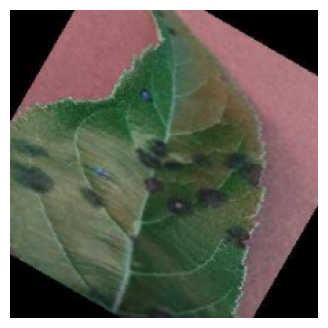

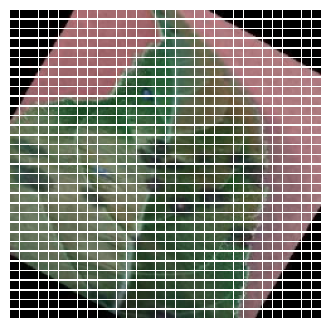

In [23]:
# Visualize patches (optional)
patch_size = 7
for x in data[4:5]:
    image = x
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    
    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(img_size, img_size)
    )
    patches = Patches(patch_size)(resized_image)
    print(f'Image size: {img_size} X {img_size}')
    print(f'Patch size: {patch_size} X {patch_size}')
    print(f'Patches per image: {patches.shape[1]}')
    print(f'Elements per patch: {patches.shape[-1]}')

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy().astype('uint8'))
        plt.axis('off')

In [24]:
# Create ViT feature extractor model
vit_feature_model = tf.keras.Sequential([
    vit_lambda,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation="relu")
],
name='vision_transformer')

In [25]:
vit_feature_model.save('b6vit_model.keras')

c:\Users\A\Downloads\PlantDiseaseProject\venv\lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [26]:
def extract_vit_features(model, dataset):
    features = model.predict(dataset)
    return np.vstack(features)

In [27]:
vit_features = extract_vit_features(vit_feature_model, data)


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


547/547 ━━━━━━━━━━━━━━━━━━━━ 3306s 6s/step


In [28]:
def create_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = L.GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [29]:
def extract_resnet_features(model, dataset):
    features = model.predict(dataset)
    return np.vstack(features)

In [30]:
res_model = create_resnet_model((224, 224, 3))
res_features = extract_resnet_features(res_model, data)
res_model.save('b6resnet_model.keras')

547/547 ━━━━━━━━━━━━━━━━━━━━ 893s 2s/step


In [31]:
print("ResNet features shape:", res_features.shape)
print("ViT features shape:", vit_features.shape)

ResNet features shape: (17490, 2048)
ViT features shape: (17490, 1000)


In [32]:
bottleneck_features = L.Concatenate()([res_features, vit_features])
bottleneck_features = np.array(bottleneck_features)
print("Combined features shape:", bottleneck_features.shape)

Combined features shape: (17490, 3048)


In [33]:
# Define final classifier model
def build_sequential_model(input_shape, num_classes):
    model = Sequential()
    model.add(L.Flatten(input_shape=input_shape))
    model.add(L.Dense(1024, activation='relu'))
    model.add(L.Dense(256, activation='relu'))
    model.add(L.Dense(64, activation='relu'))
    model.add(L.Dense(num_classes, activation='softmax'))
    return model

In [34]:
num_classes = target.shape[1]
input_shape = bottleneck_features.shape[1:]

In [35]:
model2 = build_sequential_model(input_shape, num_classes)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

c:\Users\A\Downloads\PlantDiseaseProject\venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 3048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     3,122,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,403,169 (12.98 MB)

 Trainable params: 3,403,169 (12.98 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
train_data, test_data, train_target, test_target = train_test_split(bottleneck_features, target, test_size=0.2)
train_data, val_data, train_target, val_target = train_test_split(train_data, train_target, test_size=0.1)


In [37]:
model2.fit(train_data, train_target, epochs=10, validation_data=(val_data, val_target), batch_size=64)


Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5604 - loss: 1.6079 - val_accuracy: 0.9086 - val_loss: 0.3035
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9400 - loss: 0.1854 - val_accuracy: 0.9371 - val_loss: 0.2219
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9707 - loss: 0.0934 - val_accuracy: 0.9579 - val_loss: 0.1333
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9774 - loss: 0.0722 - val_accuracy: 0.9479 - val_loss: 0.1665
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9774 - loss: 0.0682 - val_accuracy: 0.9514 - val_loss: 0.1509
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9884 - loss: 0.0361 - val_accuracy: 0.9450 - val_loss: 0.1882
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9799 - loss: 0.0629 - val_accuracy: 0.9671 - val_loss: 0.1095
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9838 - loss: 0.0473 - val_acc

In [38]:
# Evaluate the model
loss, acc = model2.evaluate(test_data, test_target)
print('Test accuracy:', acc)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9716 - loss: 0.1059
Test accuracy: 0.9665523171424866


In [39]:
model2.save('b6vit_resnet_model2.keras')

In [46]:
# Define class labels (adjust based on your actual data)
l = [
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___healthy',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot',
    'Grape___healthy',
    'Grape__Leaf_blight(Isariopsis_Leaf_Spot)',
    'Potato___Early_blight',
    'Potato___healthy',
    'Potato___Late_blight',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy'
]
d = {i: j for i, j in enumerate(l)}



In [47]:
y_pred_prob = model2.predict(test_data)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_target, axis=1)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [49]:
missing_keys = [i for i in y_true if i not in d]
print("Missing keys in dictionary:", missing_keys)
print(d.keys())
d = {int(k): v for k, v in d.items()}  # Convert keys to int
true_classes_labels = [d.get(i, "Unknown") for i in y_true]
predicted_classes_labels = [d.get(i, "Unknown") for i in y_pred]
print(set(y_true))
print(set(y_pred))


Missing keys in dictionary: [np.int64(24), np.int64(25), np.int64(16), np.int64(29), np.int64(21), np.int64(23), np.int64(27), np.int64(19), np.int64(15), np.int64(21), np.int64(23), np.int64(29), np.int64(31), np.int64(20), np.int64(20), np.int64(26), np.int64(17), np.int64(20), np.int64(18), np.int64(18), np.int64(30), np.int64(20), np.int64(20), np.int64(19), np.int64(21), np.int64(31), np.int64(20), np.int64(26), np.int64(15), np.int64(24), np.int64(28), np.int64(28), np.int64(16), np.int64(24), np.int64(21), np.int64(21), np.int64(30), np.int64(28), np.int64(24), np.int64(17), np.int64(27), np.int64(24), np.int64(16), np.int64(22), np.int64(24), np.int64(32), np.int64(27), np.int64(24), np.int64(18), np.int64(20), np.int64(31), np.int64(17), np.int64(27), np.int64(28), np.int64(19), np.int64(26), np.int64(16), np.int64(30), np.int64(32), np.int64(24), np.int64(23), np.int64(28), np.int64(27), np.int64(25), np.int64(22), np.int64(26), np.int64(18), np.int64(21), np.int64(25), np.in

In [50]:
print("\n===== BASIC METRICS =====")
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")


===== BASIC METRICS =====
Accuracy: 0.9666
Precision (Macro): 0.9683
Precision (Weighted): 0.9688
Recall (Macro): 0.9669
Recall (Weighted): 0.9666
F1 Score (Macro): 0.9663
F1 Score (Weighted): 0.9665


In [57]:
from sklearn.metrics import classification_report

# Manually update target names if needed (Ensure 33 labels)
l = [
    "Apple___Black_rot", "Apple___Cedar_apple_rust", "Apple___healthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight", "Grape___Black_rot", "Grape___Esca_(Black_Measles)",
    "Grape___healthy", "Grape___Leaf_blight(Isariopsis_Leaf_Spot)", "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot", "Pepper,_bell___Bacterial_spot", "Pepper,_bell___healthy",
    "Potato___Early_blight", "Potato___healthy", "Potato___Late_blight", "Raspberry___healthy",
    "Soybean___healthy", "Squash___Powdery_mildew", "Strawberry___Leaf_scorch",
    "Strawberry___healthy", "Tomato___Bacterial_spot", "Tomato___Early_blight",
    "Tomato___Late_blight", "Tomato___Leaf_Mold", "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite", "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus", "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___healthy"
]

# Verify number of unique labels
num_classes = len(set(y_true) | set(y_pred))
print("Number of unique classes:", num_classes)
print("Length of target_names:", len(l))

# Ensure target_names matches the number of unique classes
if len(l) != num_classes:
    print("Error: target_names length does not match number of classes.")
    print("Please update the target_names list to include all 33 class labels.")
else:
    # Generate classification report
    print("\n===== CLASSIFICATION REPORT =====")
    class_report = classification_report(y_true, y_pred, target_names=l)
    print(class_report)


Number of unique classes: 33
Length of target_names: 32
Error: target_names length does not match number of classes.
Please update the target_names list to include all 33 class labels.


In [58]:
print("\n===== CONFUSION MATRIX =====")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=l, yticklabels=l)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()
print("Confusion matrix saved as 'confusion_matrix.png'")


===== CONFUSION MATRIX =====
Confusion matrix saved as 'confusion_matrix.png'


In [59]:
print("\n===== PER-CLASS METRICS =====")
class_precision = precision_score(y_true, y_pred, average=None)
class_recall = recall_score(y_true, y_pred, average=None)
class_f1 = f1_score(y_true, y_pred, average=None)

metrics_df = {
    'Class': l,
    'Precision': class_precision,
    'Recall': class_recall,
    'F1-Score': class_f1
}



===== PER-CLASS METRICS =====


In [60]:
print("{:<40} {:<12} {:<12} {:<12}".format('Class', 'Precision', 'Recall', 'F1-Score'))
print("-" * 80)
for i in range(len(l)):
    print("{:<40} {:<12.4f} {:<12.4f} {:<12.4f}".format(
        metrics_df['Class'][i], 
        metrics_df['Precision'][i], 
        metrics_df['Recall'][i], 
        metrics_df['F1-Score'][i]))


Class                                    Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
Apple___Black_rot                        0.8583       1.0000       0.9238      
Apple___Cedar_apple_rust                 1.0000       0.9000       0.9474      
Apple___healthy                          1.0000       0.9907       0.9953      
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 0.9845       0.9695       0.9769      
Corn_(maize)___healthy                   0.9515       1.0000       0.9751      
Corn_(maize)___Northern_Leaf_Blight      0.9905       0.9811       0.9858      
Grape___Black_rot                        1.0000       0.9065       0.9510      
Grape___Esca_(Black_Measles)             0.9667       0.9748       0.9707      
Grape___healthy                          1.0000       1.0000       1.0000      
Grape___Leaf_blight(Isariopsis_Leaf_Spot) 1.0000       1.0000       1.0000      
Orange___Haunglongbing_(Citr


===== ROC CURVES AND AUC SCORES =====
Average AUC: 0.9998


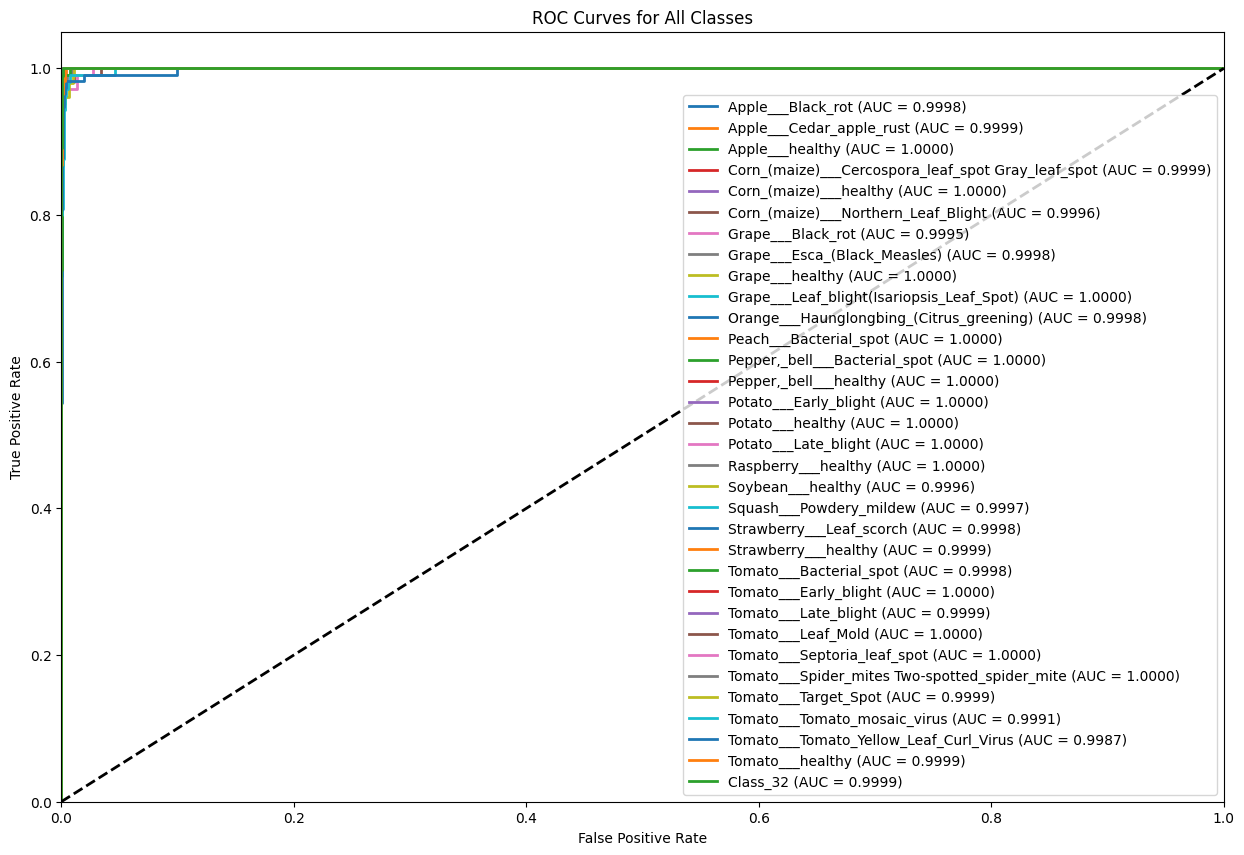

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print("\n===== ROC CURVES AND AUC SCORES =====")
plt.figure(figsize=(15, 10))

# Ensure target_names (l) has the right number of labels
if len(l) < num_classes:
    print(f"Warning: Expected {num_classes} labels, but got {len(l)}. Auto-filling missing labels.")
    l += [f"Class_{i}" for i in range(len(l), num_classes)]  # Fill missing labels
elif len(l) > num_classes:
    print(f"Warning: More target names ({len(l)}) than classes ({num_classes}). Trimming extra labels.")
    l = l[:num_classes]  # Trim extra labels

auc_scores = []
for i in range(num_classes):
    # Convert to one-vs-rest binary classification for this class
    y_true_binary = (y_true == i).astype(int)

    # Ensure y_pred_prob has the correct shape
    if y_pred_prob.shape[1] < num_classes:
        print(f"Warning: y_pred_prob has only {y_pred_prob.shape[1]} class probabilities. Adjusting range.")
        break  # Stop if predictions are incomplete

    y_score = y_pred_prob[:, i]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{l[i]} (AUC = {roc_auc:.4f})')

# Calculate and print average AUC
if auc_scores:
    average_auc = np.mean(auc_scores)
    print(f"Average AUC: {average_auc:.4f}")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc="lower right")
plt.show()


In [64]:
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc="lower right", fontsize='small')
plt.savefig('roc_curves.png')
plt.close()
print("ROC curves saved as 'roc_curves.png'")

ROC curves saved as 'roc_curves.png'


C:\Users\A\AppData\Local\Temp\ipykernel_6172\3547718078.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right", fontsize='small')


In [65]:
print("\n===== PRECISION-RECALL CURVES =====")
plt.figure(figsize=(15, 10))



===== PRECISION-RECALL CURVES =====


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

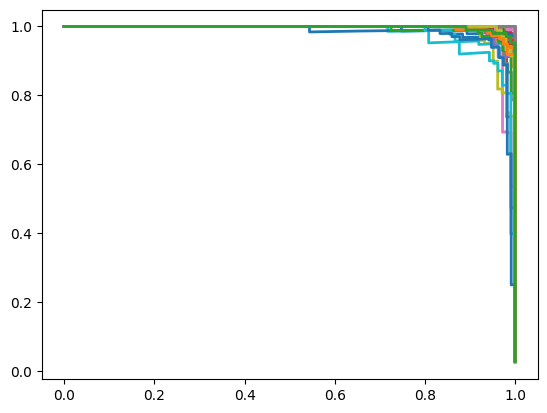

In [66]:
ap_scores = []
for i in range(num_classes):
    # Convert to one-vs-rest binary classification for this class
    y_true_binary = (y_true == i).astype(int)
    y_score = y_pred_prob[:, i]
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
    ap = average_precision_score(y_true_binary, y_score)
    ap_scores.append(ap)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, lw=2, label=f'{l[i]} (AP = {ap:.4f})')


In [67]:
average_ap = np.mean(ap_scores)
print(f"Average Precision (AP): {average_ap:.4f}")

# Plot the precision-recall curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-Class Classification')
plt.legend(loc="best", fontsize='small')
plt.savefig('precision_recall_curves.png')
plt.close()
print("Precision-Recall curves saved as 'precision_recall_curves.png'")


Average Precision (AP): 0.9962
Precision-Recall curves saved as 'precision_recall_curves.png'


C:\Users\A\AppData\Local\Temp\ipykernel_6172\1066039712.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best", fontsize='small')


In [77]:
history = model2.fit(train_data, train_target, validation_data=(val_data, val_target), epochs=10, batch_size=32)


Epoch 1/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9469 - loss: 0.1762 - val_accuracy: 0.9607 - val_loss: 0.1357
Epoch 2/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9791 - loss: 0.0655 - val_accuracy: 0.9514 - val_loss: 0.1861
Epoch 3/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9836 - loss: 0.0507 - val_accuracy: 0.9657 - val_loss: 0.1282
Epoch 4/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9845 - loss: 0.0484 - val_accuracy: 0.9671 - val_loss: 0.1164
Epoch 5/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9934 - loss: 0.0215 - val_accuracy: 0.9550 - val_loss: 0.1462
Epoch 6/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9800 - loss: 0.0591 - val_accuracy: 0.9579 - val_loss: 0.1479
Epoch 7/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9913 - loss: 0.0289 - val_accuracy: 0.9693 - val_loss: 0.1235
Epoch 8/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9905 - loss: 0.0328 - 


===== TRAINING HISTORY =====


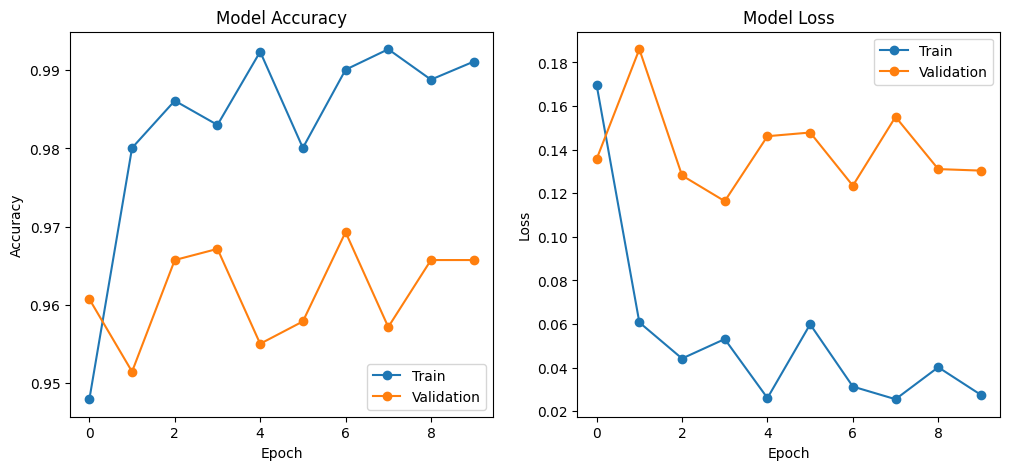

In [78]:
import matplotlib.pyplot as plt

print("\n===== TRAINING HISTORY =====")

# Check if 'history' is defined
if 'history' not in globals():
    print("Error: 'history' is not defined. Make sure you trained the model before plotting.")
else:
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('accuracy', []), marker='o')
    plt.plot(history.history.get('val_accuracy', []), marker='o')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('loss', []), marker='o')
    plt.plot(history.history.get('val_loss', []), marker='o')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()


In [79]:
plt.tight_layout()
plt.savefig('training_history.png')
plt.close()
print("Training history saved as 'training_history.png'")


Training history saved as 'training_history.png'


In [80]:
# 8. Final Summary
print("\n===== PERFORMANCE SUMMARY =====")
print(f"Model: Ensemble of ResNet50 and ViT-B16")
print(f"Total number of classes: {num_classes}")
print(f"Total samples evaluated: {len(y_true)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")
print(f"Average AUC: {average_auc:.4f}")
print(f"Average Precision: {average_ap:.4f}")
print("\nTop 3 performing classes:")
sorted_indices = np.argsort(class_f1)[::-1]
for i in range(3):
    idx = sorted_indices[i]
    print(f"  {i+1}. {l[idx]}: F1={class_f1[idx]:.4f}, Precision={class_precision[idx]:.4f}, Recall={class_recall[idx]:.4f}")

print("\nBottom 3 performing classes:")
for i in range(1, 4):
    idx = sorted_indices[-i]
    print(f"  {i}. {l[idx]}: F1={class_f1[idx]:.4f}, Precision={class_precision[idx]:.4f}, Recall={class_recall[idx]:.4f}")


===== PERFORMANCE SUMMARY =====
Model: Ensemble of ResNet50 and ViT-B16
Total number of classes: 33
Total samples evaluated: 3498
Accuracy: 0.9666
Macro F1-Score: 0.9663
Average AUC: 0.9998
Average Precision: 0.9962

Top 3 performing classes:
  1. Tomato___Leaf_Mold: F1=1.0000, Precision=1.0000, Recall=1.0000
  2. Grape___healthy: F1=1.0000, Precision=1.0000, Recall=1.0000
  3. Grape___Leaf_blight(Isariopsis_Leaf_Spot): F1=1.0000, Precision=1.0000, Recall=1.0000

Bottom 3 performing classes:
  1. Tomato___Tomato_Yellow_Leaf_Curl_Virus: F1=0.8932, Precision=1.0000, Recall=0.8070
  2. Squash___Powdery_mildew: F1=0.9167, Precision=0.8462, Recall=1.0000
  3. Soybean___healthy: F1=0.9215, Precision=1.0000, Recall=0.8544
